The results in this notebook, recreates the results in our report. The results might differ slightly from what is in the report as a result of chance (eg: GMM, ANN drop-out, etc) or minore changes in filtering of data (here all data is initialy importet and filtered for NaN based on all variables. Some of the data in the report was generated by filtering on just the NaN values in the relevant variables for that part or a subset of all our variables.). However, the results in this Note book shows our approach in each section and does recreate most of the results identicaly. 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
from scipy import linalg
from sklearn import preprocessing

from sklearn import mixture
import sklearn.metrics as metrics
import pylab as pl

# Part 1:
## Organize and configure data for this notebook

In [2]:
# financial data
DJI_df = pd.read_csv('^DJI.csv')[['Date', 'Adj Close']]
TNX_df = pd.read_csv('^TNX.csv')[['Date', 'Adj Close']]
unemployment_df = pd.read_csv('unemployment.csv')

# educational data
gr_en_df = pd.read_csv('graduationAndEnrollment.csv', index_col=0)
rank_df = pd.read_csv('schools_ranking.csv', index_col=0).drop(['name'], axis=1)
sfa_df = pd.read_csv('student_financial_aid.csv', index_col=0)
uni_finance_df = pd.read_csv('university_financial.csv', index_col=0)

usa_gdf = gpd.read_file("gz_2010_us_040_00_20m.json")
uni_gdf = gpd.read_file("uni_geo_location.geojson")

edu_df = pd.merge(gr_en_df,rank_df, left_on='UNITID', right_on='UNITID', how='left')
# add rank 181, if not included in the top 180 ranking
edu_df['Rank'] = edu_df['Rank'].fillna(181)
edu_df = pd.merge(edu_df,sfa_df.drop('TYPE', axis=1), left_on='UNITID', right_on='UNITID', how='inner')
edu_df = pd.merge(edu_df,uni_finance_df.drop('TYPE', axis=1), left_on='UNITID', right_on='UNITID', how='inner')

edu_change_df = pd.read_csv('percentage_change_all_vars.csv', index_col=0)



In [3]:
# make graduation and enrollment columns follow same nameing 
# convention as other columns
cols = edu_df.columns.tolist()
for i in range(len(cols)):
    if cols[i][0] == 'g':
        endYear = cols[i][-2:]
        beginingYear = str(int(endYear)-1).zfill(2)
        cols[i] = beginingYear + endYear + '_' + 'GR'
    elif cols[i][0] == 'e':
        endYear = cols[i][-2:]
        beginingYear = str(int(endYear)-1).zfill(2)
        cols[i] = beginingYear + endYear + '_' + 'EN'
edu_df.columns = cols


In [4]:
#Drop rows with missing data
edu_df = edu_df.dropna(how='any') 
edu_change_df = edu_change_df.dropna(how='any') 

In [5]:
list_all_uni = pd.merge(edu_df[['UNITID']], edu_change_df[['UNITID']], left_on='UNITID', right_on='UNITID', how='inner' )

In [6]:
edu_df = pd.merge(edu_df,list_all_uni, left_on='UNITID', right_on='UNITID', how='inner')
edu_change_df = pd.merge(edu_change_df,list_all_uni, left_on='UNITID', right_on='UNITID', how='inner')


# ----------------------------------------------------

# Part2:
## Analysis

datasets available:

edu_df

edu_change_df

uni_gdf

usa_gdf

DJI_df

TNX_df

unemployment_df

-----------------------------------------------
#### Plot of weekly adjusted closing price for DJIA

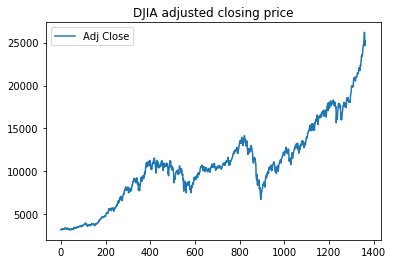

In [7]:
DJI_df.plot(title="DJIA adjusted closing price")
plt.show()

#### Plot of US Unemployment rate from 

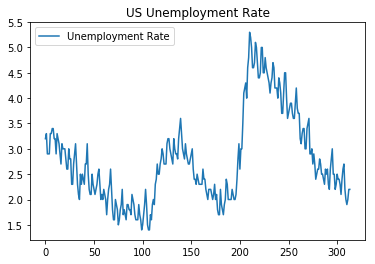

In [8]:
unemployment_df.plot(title="US Unemployment Rate")
plt.legend(['Unemployment Rate'])
plt.show()

#### 10-year bond yields vs total student loans – correlation and best fit

/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


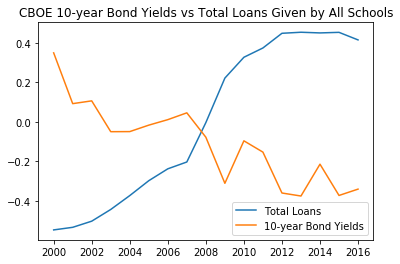

In [9]:
#Normalized aggregate sum of all students loans (blue) 
#normalized CBOE 10-year bond yields (orange)
TNX_normalized_df = TNX_df.copy()
adjClose  = TNX_normalized_df['Adj Close'].values
closeMin  = np.min(adjClose)
closeMax  = np.max(adjClose)
closeMean = np.mean(adjClose)
TNX_normalized_df['Adj Close'] = TNX_normalized_df['Adj Close'].apply(lambda x: (x-closeMean)/(closeMax-closeMin))
TNX_normalized_df.columns = ['Date', "10-year Bond Yields"]

totalLoans = edu_df[['9900_LOAN_A','0001_LOAN_A','0102_LOAN_A','0203_LOAN_A','0304_LOAN_A','0405_LOAN_A','0506_LOAN_A','0607_LOAN_A','0708_LOAN_A','0809_LOAN_A','0910_LOAN_A','1011_LOAN_A','1112_LOAN_A','1213_LOAN_A','1314_LOAN_A','1415_LOAN_A','1516_LOAN_A',
                     '9900_LOAN_N','0001_LOAN_N','0102_LOAN_N','0203_LOAN_N','0304_LOAN_N','0405_LOAN_N','0506_LOAN_N','0607_LOAN_N','0708_LOAN_N','0809_LOAN_N','0910_LOAN_N','1011_LOAN_N','1112_LOAN_N','1213_LOAN_N','1314_LOAN_N','1415_LOAN_N','1516_LOAN_N']]

for col1 in totalLoans.columns:
    for col2 in totalLoans.columns:
        if col1[:10] == col2[:10] and col1[-1]=='A' and col2[-1] == 'N':
            totalLoans[col1[:10] + 'T'] = totalLoans[col1] * totalLoans[col2]
            totalLoans = totalLoans.drop( [col1, col2], axis=1)
            
totalLoans = totalLoans.sum(axis=0).tolist()
dates = ['2000-01-05', '2001-01-03', '2002-01-02', '2003-01-01', '2004-01-07', '2005-01-05', 
         '2006-01-04', '2007-01-03', '2008-01-02', '2009-01-07', '2010-01-06', '2011-01-05', 
         '2012-01-04', '2013-01-02', '2014-01-01', '2015-01-07', '2016-01-06']

totalLoans_df = pd.DataFrame()
totalLoans_df['Date'] = dates
totalLoans_df['Total Loans'] = totalLoans

totalLoans  = totalLoans_df['Total Loans'].values
loanMin  = np.min(totalLoans)
loanMax  = np.max(totalLoans)
loanMean = np.mean(totalLoans)
totalLoans_df['Total Loans'] = totalLoans_df['Total Loans'].apply(lambda x: (x-loanMean)/(loanMax-loanMin))

plot_df = pd.merge(totalLoans_df, TNX_normalized_df, left_on='Date', right_on='Date', how='inner')
plt.figure(figsize=(5,5))
plot_df.plot(title='CBOE 10-year Bond Yields vs Total Loans Given by All Schools')
plt.xticks(range(0,17,2),list(range(2000,2017,2)))
plt.show()

In [10]:
print('Correlation between CBOE 10-year Bond Yields and Total Loans Given by All Schools:', plot_df['Total Loans'].corr(plot_df['10-year Bond Yields']))

Correlation between CBOE 10-year Bond Yields and Total Loans Given by All Schools: -0.8734087678746737


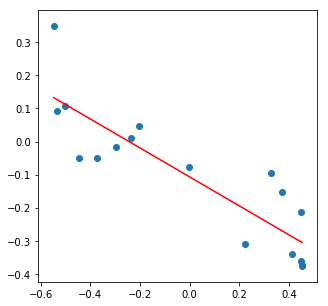

In [11]:
plt.figure(figsize=(5,5))
plt.scatter(plot_df['Total Loans'], plot_df['10-year Bond Yields'])
plt.plot(np.unique(plot_df['Total Loans']), np.poly1d(np.polyfit(plot_df['Total Loans'], plot_df['10-year Bond Yields'], 1))(np.unique(plot_df['Total Loans'])), c='red' )
plt.show()

In [12]:
bestFitLine = np.polyfit(plot_df['Total Loans'], plot_df['10-year Bond Yields'], 1)
print("Best line fit to normalized Total Loans and 10-year Bond Yields: y = " + str(round(bestFitLine[1], 3)) + str(round(bestFitLine[0], 3)) + 'x')

Best line fit to normalized Total Loans and 10-year Bond Yields: y = -0.107-0.437x


#### Map of location of all higher educational institution used in our study

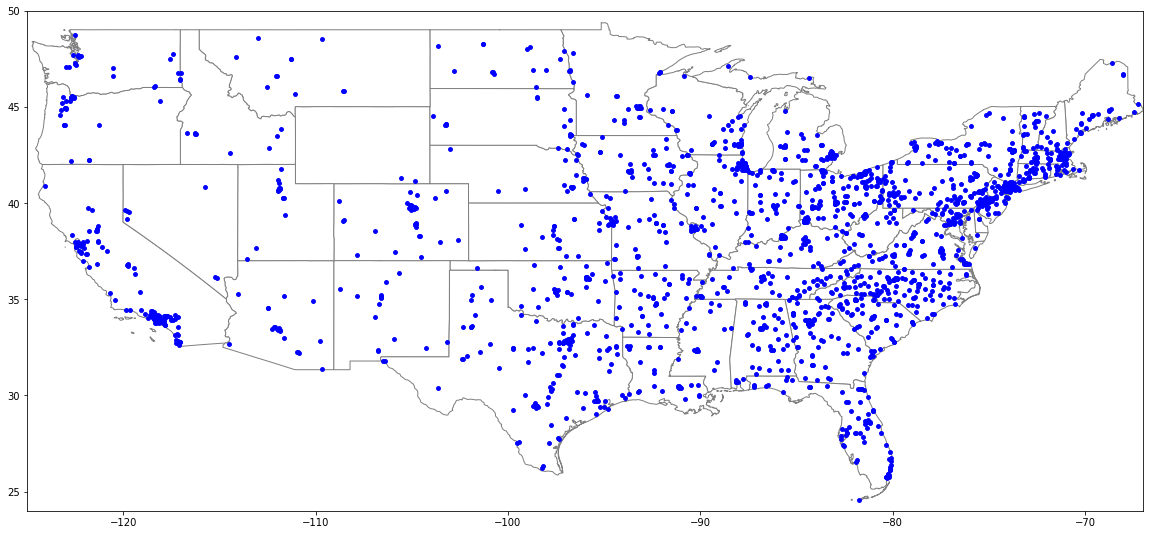

In [13]:
plt.rcParams['figure.figsize'] = (20, 20)



USA_base = usa_gdf.plot(color='white', edgecolor='grey')
USA_base.set_xlim([-125.00, -67.00])
USA_base.set_ylim([24.00, 50.00])

uni_gdf.plot(ax=USA_base, marker='o', color='blue', markersize=15);

#### Map of not-for-profit schools – color coded to show change in enrollment during 2008/2009

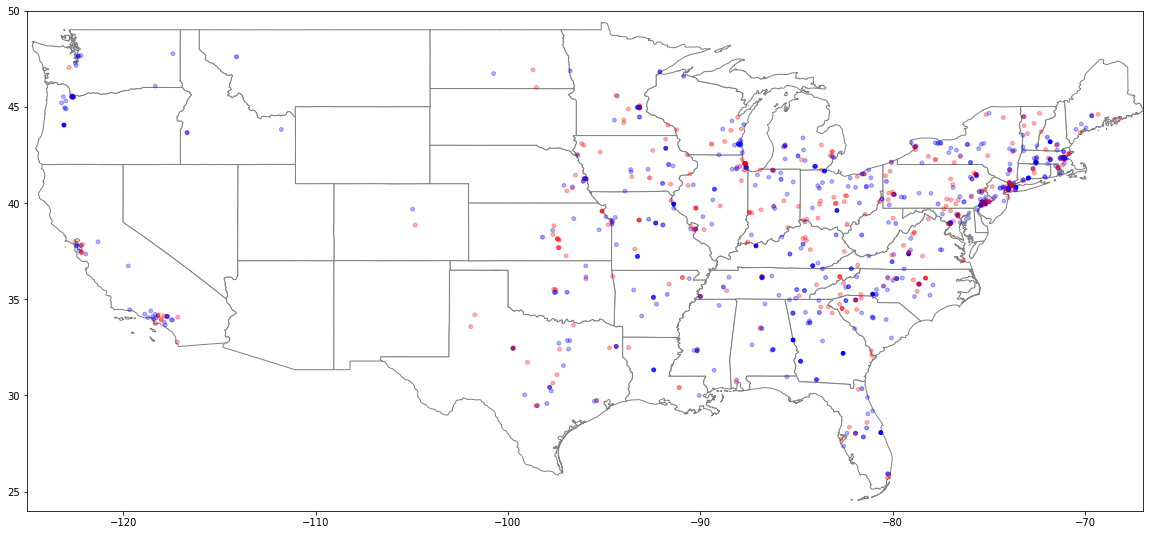

In [14]:
plt.rcParams['figure.figsize'] = (20, 20)


edu_change_df_not_for_profit = edu_change_df.loc[(edu_change_df['TYPE'] == 'not-for-profit')]
uni_not_for_profit_df = pd.merge(uni_gdf,edu_change_df_not_for_profit[['UNITID','0809_EN']], left_on='UNITID', right_on='UNITID', how='inner')

colors = uni_not_for_profit_df["0809_EN"].tolist()
colors = [(0.0, 0.0, 1, max(0.3,min(1,x/20)) ) if x > 0.1 else ( (1, 0.0, 0.0, max(0.3, min(1,abs(x/20)))) if x < 0 else (0,0,0,0)) for x in colors]

USA_base = usa_gdf.plot(color='white', edgecolor='grey')
USA_base.set_xlim([-125.00, -67.00])
USA_base.set_ylim([24.00, 50.00])

uni_not_for_profit_df.plot(ax=USA_base, marker='o', c=colors, markersize=15);

#### Map of public schools – color coded to show change in enrollment during 2008/2009

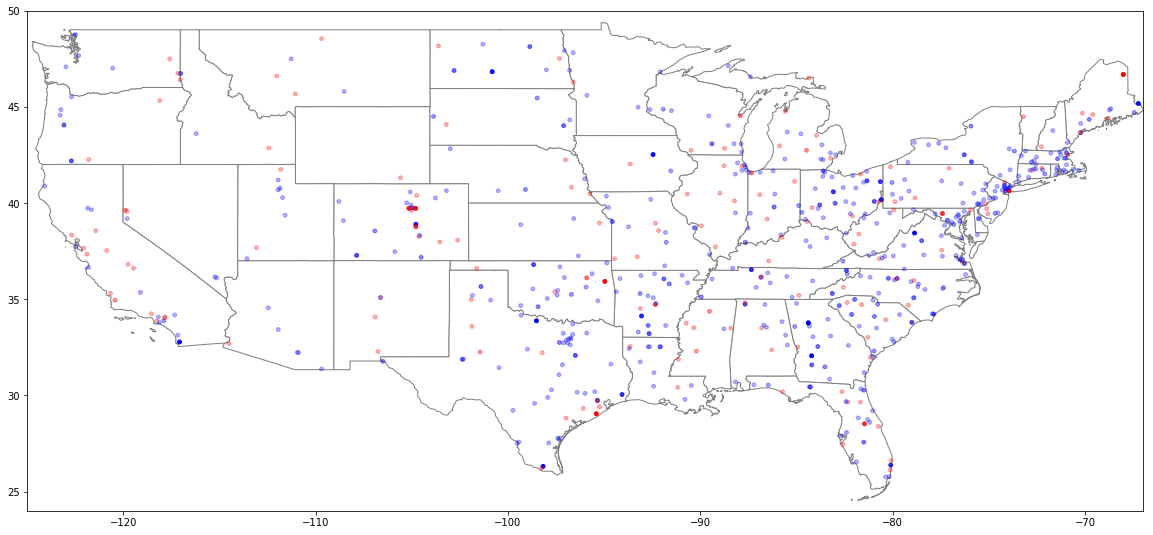

In [15]:
plt.rcParams['figure.figsize'] = (20, 20)


edu_change_df_public = edu_change_df.loc[(edu_change_df['TYPE'] == 'public')]
uni_public_df = pd.merge(uni_gdf,edu_change_df_public[['UNITID','0809_EN']], left_on='UNITID', right_on='UNITID', how='inner')

colors = edu_change_df_public["0809_EN"].tolist()
colors = [(0.0, 0.0, 1, max(0.3,min(1,x/20)) ) if x > 0.1 else ( (1, 0.0, 0.0, max(0.3, min(1,abs(x/20)))) if x < 0 else (0,0,0,0)) for x in colors]

USA_base = usa_gdf.plot(color='white', edgecolor='grey')
USA_base.set_xlim([-125.00, -67.00])
USA_base.set_ylim([24.00, 50.00])

uni_public_df.plot(ax=USA_base, marker='o', c=colors, markersize=15);

#### Aggregated results over type of school (mean research expences and median number of enrolments)

In [16]:

# Extracts from a data frame all columns matching varNames and years
# as well as UNITID and TYPE
# Input: Data frame
#        list of var names i.e: ["LOAN_A"]
#        list of school years i.e ["0809"]
#
# Output: a new df with the specified columns in the specified period
def extractRelevantData(df, varNames, years):
    cols = ["UNITID", 'TYPE', 'Rank']
    for var in varNames:
        for year in years:
            col = year + "_" + var
            cols.append(col)
    return df[cols]

#!!Side Effects (change original dataframe)!!
#preforms 2D-PCA on data and add "PCA_X"/"_Y" to the df
#Input: df, list of vars to exclude (i.e UNITID)
#Output: NOTHING! HAS SIDE EFFECTS
def dataWithPCA2D(df):
    cols = df.columns.difference(["UNITID", "TYPE", "Rank"])
    u, s, vt = linalg.svd(preprocessing.scale(df[cols].values))
    PCA = u[:,:2] @ np.diag(s[:2])
    df['PCA_X']  = PCA[:,0] 
    df['PCA_Y']  = PCA[:,1]  
    
#Determine number of cluster in GMM
def sc_evaluate_clusters_GMM(X,max_clusters, title="GMM Silhouette Score", fig=True, fig_size=(12, 6)):
    s = np.zeros(max_clusters+1)
    for k in range(2,max_clusters+1):
        gmm = mixture.GaussianMixture(n_components=k, covariance_type='full')
        gmm.fit(X)
        y_pred = gmm.predict(X)
        s[k] = metrics.silhouette_score(X,y_pred,metric='euclidean')
    if fig:
        plt.figure(figsize=fig_size)
        plt.plot(range(2,len(s)),s[2:])
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.title(title)
        plt.show()

#!!Side Effects (change original dataframe)!!
# Finds a GMM clustering of the data
#input: df, k = number of clusters, special variables that should get
#       removed before clustering, bool = get Silhouette socre graph
#
#output: NO OUTPUT. HAS SIDE EFFECTS by adding ["CLUSTER"] to df
def clusterData(df, k, specialVarsToExlude=[], getScGraph = True):
    cols = df.columns.difference(["UNITID", "TYPE", "Rank"]+specialVarsToExlude)
    scaled_data = preprocessing.scale(df[cols].values)
    if getScGraph:
        sc_evaluate_clusters_GMM(scaled_data, 12)
    gmm = mixture.GaussianMixture(n_components=k, covariance_type='full')
    gmm.fit(scaled_data)
    pred = gmm.predict(scaled_data)
    df["CLUSTER"] = pred

# Prints out a 2D-PCA scatter plot of all the points, colored by cluster
# Input: df, number of clusters, title of plot, column name of clustering
# Output: Nothing
def graphClusters(df, k, title, clusterCol="CLUSTER", clusterVals=[]):
    plt.figure(figsize=(10,10))
    c = [None]*k
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    if clusterVals == []:
        for idx, row in df.iterrows():
            c[row[clusterCol]] = pl.scatter(row['PCA_X'],row['PCA_Y'],c=colors[row[clusterCol]],s=12, alpha=0.2)
        pl.legend(c, range(k))
    else:
        clusterMaping = {}
        for i in range(len(clusterVals)):
            clusterMaping[clusterVals[i]] = i
        for idx, row in df.iterrows():
            c[clusterMaping[row[clusterCol]]] = pl.scatter(row['PCA_X'],row['PCA_Y'],c=colors[clusterMaping[row[clusterCol]]],s=12, alpha=0.2)
        pl.legend(c, clusterVals)
    pl.title(title)
    pl.show()

    
# Gives statistics about the different groups in the data set
# Input: df, type of statistical operation, column to cluster on ("CLUSTER" or "TYPE" or "")
# output: output the statistical results in new df
def dataStatistics(df_in, agregation, clusterCol=""):
    exclude =["UNITID", "PCA_X", "PCA_Y"]
    if clusterCol != "TYPE":
        exclude.append("TYPE")
    if clusterCol != "CLUSTER":
        exclude.append("CLUSTER")
    if agregation != "describe":
        exclude.append("Rank")
    cols = df_in.columns.difference(exclude)
    df = df_in[cols]
    
    if clusterCol != "":
        if agregation == 'sum':
            return df.groupby(clusterCol).sum()
        elif agregation == 'stdiv':
            return df.groupby(clusterCol).std()
        elif agregation == 'min':
            return df.groupby(clusterCol).min()
        elif agregation == 'max':
            return df.groupby(clusterCol).max()
        elif agregation == 'mean':
            return df.groupby(clusterCol).mean()
        elif agregation == 'median':
            return df.groupby(clusterCol).median()
        elif agregation == 'corr':
            return df.groupby(clusterCol).corr()
        elif agregation == 'cov':
            return df.groupby(clusterCol).cov()
        elif agregation == 'describe':
            return df.groupby(clusterCol).describe()
    else:
        if agregation == 'sum':
            return df.sum()
        elif agregation == 'stdiv':
            return df.std()
        elif agregation == 'min':
            return df.min()
        elif agregation == 'max':
            return df.max()
        elif agregation == 'mean':
            return df.mean()
        elif agregation == 'median':
            return df.median()
        elif agregation == 'corr':
            return df.corr()
        elif agregation == 'cov':
            return df.cov()
        elif agregation == 'describe':
            return df.describe()

#labels [first group first var, second group first var, ..., first group second var, ...]
def plotAgregates(df, variables, labels, y_unit ="", x_unit="school year", title=""):
    x = []
    for col in df.columns:
        if len(x) == 0:
            x.append(col[:4])
        else:
            if int(col[:2]) > int(x[-1][:2]):
                x.append(col[:4])
            else:
                break
    dfs = []
    for i in range(len(variables)):
        dfs.append(df.iloc[:, range(len(x)*i, len(x)*(i+1))])
    
    
    ys = []
    for df_temp in dfs:
        for idx, row in df_temp.iterrows():
            temp = []
            for elm in row:
                temp.append(elm)
            ys.append(temp)
    
    plt.figure(figsize=(8,7))
    plt.title(title)
    plt.xlabel(x_unit)
    plt.ylabel(y_unit)
    for i in range(len(ys)):
        plt.plot(range(len(x)), ys[i], label=labels[i])
    plt.legend()
    plt.xticks(range(len(x)), x, rotation='vertical')
    plt.show()
    


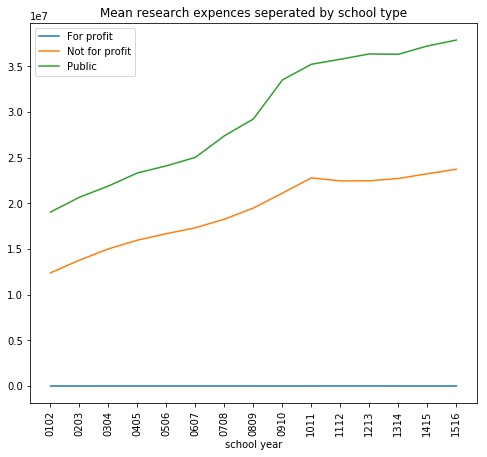

In [17]:
df_tot_spend_research = extractRelevantData(edu_df, ["RESEARCH"], ["0102","0203","0304","0405","0506","0607","0708","0809","0910","1011","1112","1213","1314","1415","1516"])
df_tot_spend_research = dataStatistics(df_tot_spend_research, "mean", clusterCol="TYPE")
plotAgregates(df_tot_spend_research, ["RESEARCH"], ["For profit","Not for profit", "Public"], title="Mean research expences seperated by school type")


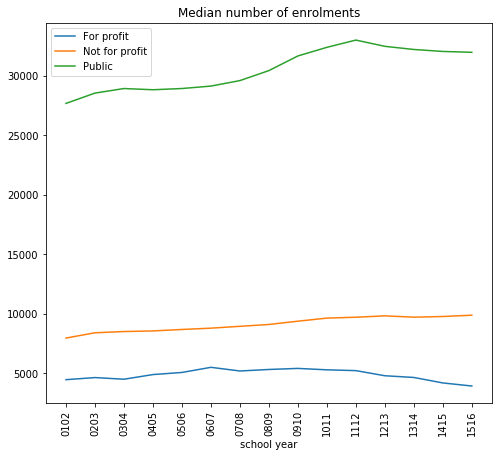

In [18]:
enrollment_df = extractRelevantData(edu_df, ["EN"], ["0102","0203","0304","0405","0506","0607","0708","0809","0910","1011","1112","1213","1314","1415","1516"])
enrollment_df = dataStatistics(enrollment_df, "mean", clusterCol="TYPE")
plotAgregates(enrollment_df, ["EN"], ["For profit","Not for profit", "Public"], title="Median number of enrolments")

#### Clustering of schools based on similair behaviour entering 2008-2009, and plot of the clusters' mean research expences and institutional grants

In [19]:

igrnt_t_df = edu_df[['9900_IGRNT_A','0001_IGRNT_A','0102_IGRNT_A','0203_IGRNT_A','0304_IGRNT_A','0405_IGRNT_A','0506_IGRNT_A','0607_IGRNT_A','0708_IGRNT_A','0809_IGRNT_A','0910_IGRNT_A','1011_IGRNT_A','1112_IGRNT_A','1213_IGRNT_A','1314_IGRNT_A','1415_IGRNT_A','1516_IGRNT_A',
                         '9900_IGRNT_N','0001_IGRNT_N','0102_IGRNT_N','0203_IGRNT_N','0304_IGRNT_N','0405_IGRNT_N','0506_IGRNT_N','0607_IGRNT_N','0708_IGRNT_N','0809_IGRNT_N','0910_IGRNT_N','1011_IGRNT_N','1112_IGRNT_N','1213_IGRNT_N','1314_IGRNT_N','1415_IGRNT_N','1516_IGRNT_N']]

for col1 in igrnt_t_df.columns:
    for col2 in igrnt_t_df.columns:
        if col1[:11] == col2[:11] and col1[-1]=='A' and col2[-1] == 'N':
            igrnt_t_df[col1[:11] + 'T'] = igrnt_t_df[col1] * igrnt_t_df[col2]
            igrnt_t_df = igrnt_t_df.drop( [col1, col2], axis=1)


            
            
loans_t_df = edu_df[['9900_LOAN_A','0001_LOAN_A','0102_LOAN_A','0203_LOAN_A','0304_LOAN_A','0405_LOAN_A','0506_LOAN_A','0607_LOAN_A','0708_LOAN_A','0809_LOAN_A','0910_LOAN_A','1011_LOAN_A','1112_LOAN_A','1213_LOAN_A','1314_LOAN_A','1415_LOAN_A','1516_LOAN_A',
                     '9900_LOAN_N','0001_LOAN_N','0102_LOAN_N','0203_LOAN_N','0304_LOAN_N','0405_LOAN_N','0506_LOAN_N','0607_LOAN_N','0708_LOAN_N','0809_LOAN_N','0910_LOAN_N','1011_LOAN_N','1112_LOAN_N','1213_LOAN_N','1314_LOAN_N','1415_LOAN_N','1516_LOAN_N']]


for col1 in loans_t_df.columns:
    for col2 in loans_t_df.columns:
        if col1[:10] == col2[:10] and col1[-1]=='A' and col2[-1] == 'N':
            loans_t_df[col1[:10] + 'T'] = loans_t_df[col1] * loans_t_df[col2]
            loans_t_df = loans_t_df.drop( [col1, col2], axis=1)


            
edu_df = edu_df.merge(igrnt_t_df, how="inner", left_index=True, right_index=True)
edu_df = edu_df.merge(loans_t_df, how="inner", left_index=True, right_index=True)



/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


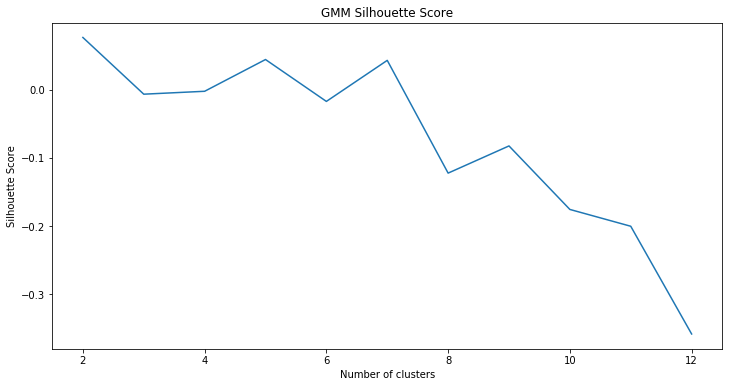

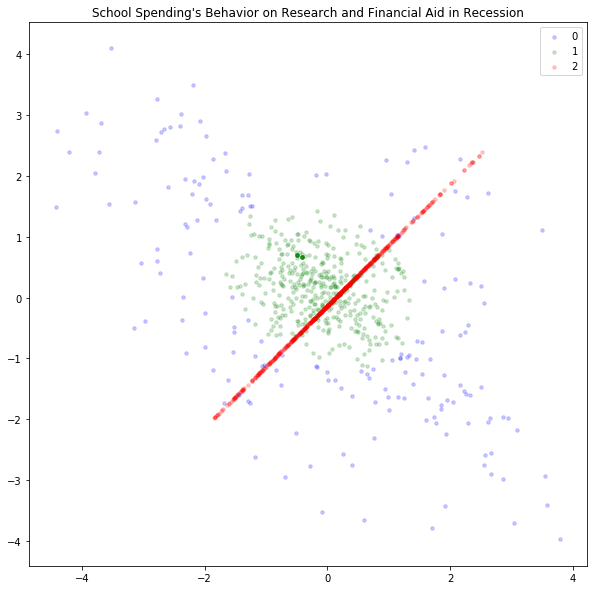

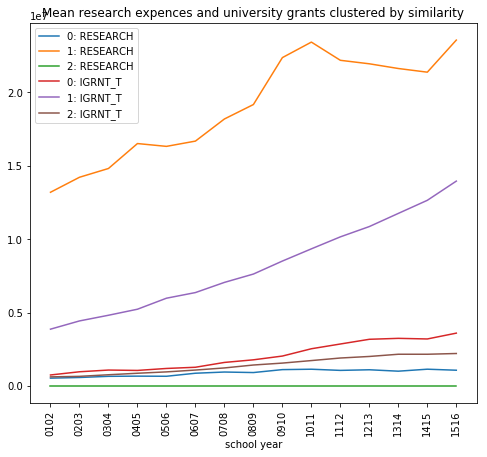

In [20]:
df_extracted = extractRelevantData(edu_change_df, ["RESEARCH", "IGRNT_T"], ["0809"])

df_extracted = df_extracted.loc[((df_extracted["0809_RESEARCH"] < 90) & 
                                 (df_extracted["0809_RESEARCH"] > -90)& 
                                 (df_extracted["0809_IGRNT_T"] < 90)  & 
                                 (df_extracted["0809_IGRNT_T"] > -90))]

dataWithPCA2D(df_extracted)
clusterData(df_extracted, 3, getScGraph = True)
graphClusters(df_extracted, 3, "School Spending's Behavior on Research and Financial Aid in Recession", clusterCol="CLUSTER")
results_clusters_percent_change = dataStatistics(df_extracted, "describe", clusterCol="CLUSTER")

original = extractRelevantData(edu_df, ["RESEARCH", "IGRNT_T"], ["0102","0203","0304","0405","0506","0607","0708","0809","0910","1011","1112","1213","1314","1415","1516"])
cols = original.columns.tolist()
df_clustering_on_original = pd.merge(original , df_extracted[['UNITID', 'CLUSTER']], left_on='UNITID', right_on='UNITID', how='inner')

results_clusters_original_data = dataStatistics(df_clustering_on_original, "median", clusterCol="CLUSTER")
results_clusters_original_data = results_clusters_original_data[cols[3:]]
description_original_data = dataStatistics(df_clustering_on_original, "describe", clusterCol="CLUSTER")

plotAgregates(results_clusters_original_data, ["RESEARCH", "IGRNT_T"], ["0: RESEARCH","1: RESEARCH", "2: RESEARCH", "0: IGRNT_T","1: IGRNT_T", "2: IGRNT_T"], title="Mean research expences and university grants clustered by similarity")



In [21]:
description_original_data['Rank']

,count,mean,std,min,25%,50%,75%,max
CLUSTER,,,,,,,,
0,172.0,174.877907,27.706739,3.0,181.0,181.0,181.0,220.0
1,520.0,125.621154,72.368975,1.0,39.0,181.0,181.0,220.0
2,670.0,180.822388,5.346564,74.0,181.0,181.0,181.0,220.0


In [22]:
types_of_schools_in_clusters = [[0,0,0],[0,0,0],[0,0,0]]
for idx, row in df_clustering_on_original.iterrows():
    cluster = row["CLUSTER"]
    school_t = row["TYPE"]
    if school_t == 'public':
        types_of_schools_in_clusters[cluster][0] += 1
    elif school_t == "not-for-profit":
        types_of_schools_in_clusters[cluster][1] += 1
    elif school_t == "for-profit":
        types_of_schools_in_clusters[cluster][2] += 1

for i in range(len(types_of_schools_in_clusters)):
    print("Cluster " + str(i) + ":")
    print("number of public schools:", types_of_schools_in_clusters[i][0])
    print("number of not-for-profit schools:", types_of_schools_in_clusters[i][1])
    print("number of for-profit schools:", types_of_schools_in_clusters[i][2])
    print()

Cluster 0:
number of public schools: 107
number of not-for-profit schools: 64
number of for-profit schools: 1

Cluster 1:
number of public schools: 203
number of not-for-profit schools: 317
number of for-profit schools: 0

Cluster 2:
number of public schools: 191
number of not-for-profit schools: 454
number of for-profit schools: 25



#### Clustering of schools based on similair behaviour of students in or entering that school in 2008-2009, and plots of the clusters' median amount of student loans

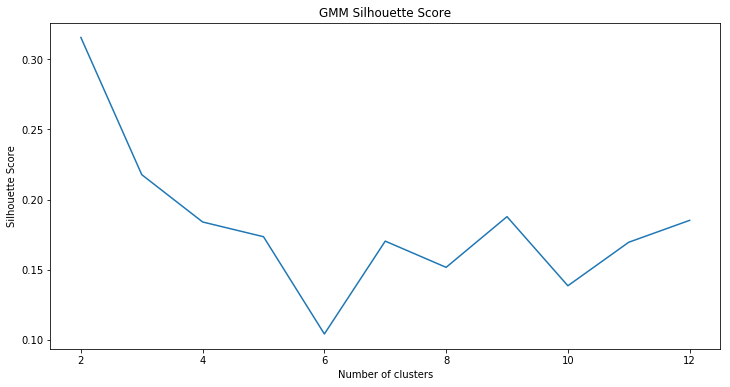

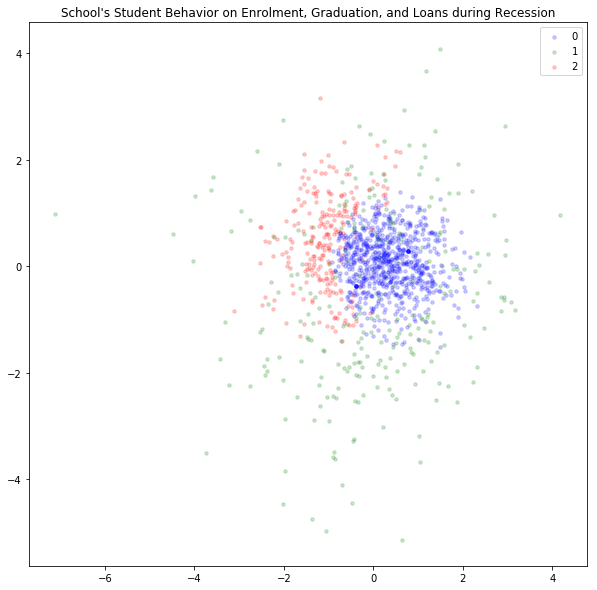

         0102_LOAN_T  0203_LOAN_T  0304_LOAN_T  0405_LOAN_T  0506_LOAN_T  \
CLUSTER                                                                    
0          1304811.0    1505768.0    1646800.0    1800814.0    1786020.0   
1           468215.0     532896.0     635316.0     658680.0     669088.0   
2           691104.0     767719.0     827387.0     973798.0     955954.0   

         0607_LOAN_T  0708_LOAN_T  0809_LOAN_T  0910_LOAN_T  1011_LOAN_T  \
CLUSTER                                                                    
0          2013410.0    2488876.0    2875444.0    3117596.0    3256800.0   
1           762550.0    1037521.0    1170936.0    1266100.0    1371270.0   
2          1041898.0    1370079.0    1987741.0    2270088.0    2202741.5   

         1112_LOAN_T  1213_LOAN_T  1314_LOAN_T  1415_LOAN_T  1516_LOAN_T  
CLUSTER                                                                   
0          3326670.0    3554613.0    3467500.0    3414810.0    3306964.0  
1          14

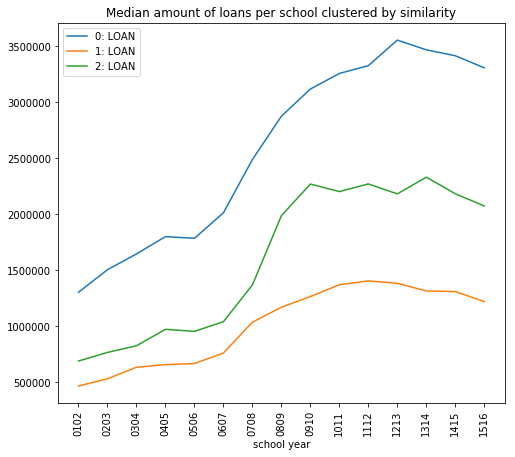

In [23]:
df_extracted = extractRelevantData(edu_change_df, ["EN", "GR", "LOAN_T"], ["0809"])

df_extracted = df_extracted.loc[((df_extracted["0809_EN"] < 90) & 
                                 (df_extracted["0809_EN"] > -90)&
                                 (df_extracted["0809_GR"] < 90) & 
                                 (df_extracted["0809_GR"] > -90)&
                                 (df_extracted["0809_LOAN_T"] < 90) & 
                                 (df_extracted["0809_LOAN_T"] > -90))]

dataWithPCA2D(df_extracted)
clusterData(df_extracted, 3, getScGraph = True)
graphClusters(df_extracted, 3, "School's Student Behavior on Enrolment, Graduation, and Loans during Recession", clusterCol="CLUSTER")
results_clusters_percent_change = dataStatistics(df_extracted, "describe", clusterCol="CLUSTER")

original = extractRelevantData(edu_df, ["EN", "GR", "LOAN_T"], ["0102","0203","0304","0405","0506","0607","0708","0809","0910","1011","1112","1213","1314","1415","1516"])
cols = original.columns.tolist()
df_clustering_on_original = pd.merge(original , df_extracted[['UNITID', 'CLUSTER']], left_on='UNITID', right_on='UNITID', how='inner')

results_clusters_original_data = dataStatistics(df_clustering_on_original, "median", clusterCol="CLUSTER")
results_clusters_original_data = results_clusters_original_data[cols[3:]]
description_original_data = dataStatistics(df_clustering_on_original, "describe", clusterCol="CLUSTER")

print(results_clusters_original_data.iloc[:,30:45])

plotAgregates(results_clusters_original_data.iloc[:,30:45], ["LOAN_T"], ["0: LOAN","1: LOAN", "2: LOAN"], title="Median amount of loans per school clustered by similarity")


#### ANN binary classification of schools based on positiv or negative change in enrolment during 2008-2009

In [24]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as pp
import matplotlib.pyplot as plt 


from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns
from __future__ import print_function
import statsmodels.api as sm
from scipy import stats

percentage_change_all_vars = edu_change_df
newdf=percentage_change_all_vars[['UNITID','TYPE','0809_GR','0809_EN','0809_ASSETS','0809_EXPENSES','0809_REVENUE','0809_RESEARCH','0809_ANYAIDN','0809_LOAN_T', '0809_FGRNT_T','0809_SGRNT_T','0809_IGRNT_T']]
newdf.head()

/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,UNITID,TYPE,0809_GR,0809_EN,0809_ASSETS,0809_EXPENSES,0809_REVENUE,0809_RESEARCH,0809_ANYAIDN,0809_LOAN_T,0809_FGRNT_T,0809_SGRNT_T,0809_IGRNT_T
0,105534,for-profit,29.049484,93.411996,61.508476,50.472747,44.947968,0.01,30.092119,34.640445,38.958976,-18.088062,196.595208
1,126605,for-profit,24.288107,4.347826,-16.670281,12.317907,12.629649,0.01,-28.076923,-48.822485,6.291402,-53.911985,13.659674
2,126702,for-profit,-8.277946,-1.377031,-4.354315,-1.478056,0.219253,0.01,-21.885522,-17.632936,28.905474,-85.551604,19.472967
3,132338,for-profit,-11.255411,-0.877706,-6.982836,-2.753620,-0.771812,0.01,-22.368421,-37.733554,-14.371541,-25.887703,-14.707282
4,138813,for-profit,-21.451744,21.061093,-3.311869,14.391678,9.940057,0.01,9.971910,27.382161,45.234526,64.646994,14.289328


In [25]:
newdf = newdf.sample(frac=1)

newdf = newdf.drop(['UNITID'], axis=1)

Dy = [1 if x > 0 else 0 for x in newdf['0809_EN'].tolist()]
Dy = np.array(Dy)

newdf = newdf.drop(['0809_EN'], axis=1)

newdf['is_for_profit']      = [(1 if x == 'for-profit'      else 0) for x in newdf['TYPE'].tolist()]
newdf['is_not_for_profit']  = [(1 if x == 'not-for-profit'  else 0) for x in newdf['TYPE'].tolist()]
newdf['is_public']          = [(1 if x == 'public'          else 0) for x in newdf['TYPE'].tolist()]
newdf['const']              = 1
newdf['0809_ANYAIDN_SQ']    = np.power(newdf['0809_ANYAIDN'], 2)
newdf['0809_EXPENSES_SQ']    = np.power(newdf['0809_EXPENSES'], 2)


newdf = newdf.drop(['TYPE'], axis=1)

for col in newdf.columns:
    print(col)

DX = newdf.values

DX = preprocessing.normalize(DX, axis=0)

0809_GR
0809_ASSETS
0809_EXPENSES
0809_REVENUE
0809_RESEARCH
0809_ANYAIDN
0809_LOAN_T
0809_FGRNT_T
0809_SGRNT_T
0809_IGRNT_T
is_for_profit
is_not_for_profit
is_public
const
0809_ANYAIDN_SQ
0809_EXPENSES_SQ


In [26]:
import math
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import Dropout
from keras.optimizers import RMSprop, Adam
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
import keras.backend as K

import datetime


#70% -> lr = 1e-05, epochs = 500,batch = 64,droputRate = 0.3,activation = 'relu',hidden_neurons_first_layer = 144, hidden_neurons_in_ratio_of_previous = 0.66

lr = 1e-05
epochs = 500
batch = 64
droputRate = 0.3

activation = 'relu'

hidden_neurons_first_layer = 144
hidden_neurons_in_ratio_of_previous = 0.66
hidden_layers = 3


def trainModel(X, y, activation, hidden_neurons_first_layer, hidden_neurons_in_ratio_of_previous, hidden_layers, lr, epochs, batch, model_name):
    # Create a Network using Keras package ------------------------------------
    model = Sequential()
    model.add(Dropout(0.4, input_shape=(len(X[0]),)))
    model.add(Dense(hidden_neurons_first_layer, init='lecun_normal', input_shape=(len(X[0]),), kernel_constraint=maxnorm(5)))
    model.add(Activation(activation))
    model.add(Dropout(droputRate, input_shape=(hidden_neurons_first_layer,)))

    neurons = hidden_neurons_first_layer
    for i in range(hidden_layers-1):
        neurons = math.ceil(neurons * hidden_neurons_in_ratio_of_previous)
        model.add(Dense(neurons, init='lecun_normal', kernel_constraint=maxnorm(5)))
        model.add(Activation(activation))
        if i < hidden_layers-1:
            model.add(Dropout(droputRate, input_shape=(hidden_neurons_first_layer,)))



    model.add(Dense(1, init='lecun_normal', activation='sigmoid'))
    
    adam = Adam(lr=lr)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X, y, epochs=epochs, verbose=2, batch_size=batch)

    model.save(model_name + '.h5')


def evaluateModel(X, y, model_name):
    model = load_model(model_name + '.h5')
    scores = model.evaluate(X_test, y_test, verbose=0)
    return(scores)


def makePrediction(x, model_name):
    model = load_model(model_name + '.h5')
    prediction = model.predict(x)
    return prediction


def preprocessData(X,y):
    numEx = X.shape[0]
    numTrain = int(math.ceil(numEx*0.7))
    return (X[:1107,:], y[:1107], X[1107:,:], y[1107:])


X,y,X_test,y_test = preprocessData(DX, Dy)

model_name = 'model_' + datetime.datetime.now().strftime("%Y%m%d%H%M%S")

trainModel(X, y, activation, hidden_neurons_first_layer, hidden_neurons_in_ratio_of_previous, hidden_layers, lr, epochs, batch, model_name)

file = open('result' + model_name + '.txt', 'w+')

file.write("#_of_training_samples,#_of_test_samples_,lr,epochs,batch,binary_crossentropy,accuracy\n")

result = evaluateModel(X_test,y_test, model_name)

file.write(str(len(X))+","+str(len(X_test))+","+str(lr)+","+str(epochs)+","+str(batch)+","+str(result[0])+","+str(result[1])+"\n")

file.close()

print("#_of_training_samples,#_of_test_samples_,lr,epochs,batch,binary_crossentropy,accuracy\n")
print(str(len(X))+","+str(len(X_test))+","+str(lr)+","+str(epochs)+","+str(batch)+","+str(result[0])+","+str(result[1])+"\n")


/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(144, input_shape=(16,), kernel_constraint=<keras.con..., kernel_initializer="lecun_normal")`
/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(96, kernel_constraint=<keras.con..., kernel_initializer="lecun_normal")`
/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, kernel_constraint=<keras.con..., kerne

Epoch 1/500
 - 0s - loss: 0.6840 - acc: 0.6621
Epoch 2/500
 - 0s - loss: 0.6480 - acc: 0.6694
Epoch 3/500
 - 0s - loss: 0.6363 - acc: 0.6694
Epoch 4/500
 - 0s - loss: 0.6339 - acc: 0.6694
Epoch 5/500
 - 0s - loss: 0.6252 - acc: 0.6694
Epoch 6/500
 - 0s - loss: 0.6314 - acc: 0.6694
Epoch 7/500
 - 0s - loss: 0.6239 - acc: 0.6694
Epoch 8/500
 - 0s - loss: 0.6253 - acc: 0.6694
Epoch 9/500
 - 0s - loss: 0.6262 - acc: 0.6694
Epoch 10/500
 - 0s - loss: 0.6197 - acc: 0.6694
Epoch 11/500
 - 0s - loss: 0.6184 - acc: 0.6694
Epoch 12/500
 - 0s - loss: 0.6207 - acc: 0.6694
Epoch 13/500
 - 0s - loss: 0.6169 - acc: 0.6694
Epoch 14/500
 - 0s - loss: 0.6195 - acc: 0.6703
Epoch 15/500
 - 0s - loss: 0.6119 - acc: 0.6694
Epoch 16/500
 - 0s - loss: 0.6230 - acc: 0.6694
Epoch 17/500
 - 0s - loss: 0.6139 - acc: 0.6694
Epoch 18/500
 - 0s - loss: 0.6174 - acc: 0.6694
Epoch 19/500
 - 0s - loss: 0.6088 - acc: 0.6703
Epoch 20/500
 - 0s - loss: 0.6098 - acc: 0.6694
Epoch 21/500
 - 0s - loss: 0.6082 - acc: 0.6694
E

Epoch 171/500
 - 0s - loss: 0.5901 - acc: 0.6820
Epoch 172/500
 - 0s - loss: 0.5905 - acc: 0.6748
Epoch 173/500
 - 0s - loss: 0.5875 - acc: 0.6983
Epoch 174/500
 - 0s - loss: 0.5902 - acc: 0.6956
Epoch 175/500
 - 0s - loss: 0.5888 - acc: 0.6938
Epoch 176/500
 - 0s - loss: 0.5885 - acc: 0.7028
Epoch 177/500
 - 0s - loss: 0.5941 - acc: 0.6730
Epoch 178/500
 - 0s - loss: 0.5873 - acc: 0.6938
Epoch 179/500
 - 0s - loss: 0.5914 - acc: 0.6784
Epoch 180/500
 - 0s - loss: 0.5927 - acc: 0.6920
Epoch 181/500
 - 0s - loss: 0.5924 - acc: 0.6902
Epoch 182/500
 - 0s - loss: 0.5881 - acc: 0.6802
Epoch 183/500
 - 0s - loss: 0.5994 - acc: 0.6694
Epoch 184/500
 - 0s - loss: 0.5994 - acc: 0.6784
Epoch 185/500
 - 0s - loss: 0.5878 - acc: 0.6920
Epoch 186/500
 - 0s - loss: 0.5861 - acc: 0.6893
Epoch 187/500
 - 0s - loss: 0.5789 - acc: 0.7010
Epoch 188/500
 - 0s - loss: 0.5858 - acc: 0.6956
Epoch 189/500
 - 0s - loss: 0.5797 - acc: 0.7037
Epoch 190/500
 - 0s - loss: 0.5830 - acc: 0.6992
Epoch 191/500
 - 0s 

 - 0s - loss: 0.5879 - acc: 0.6920
Epoch 339/500
 - 0s - loss: 0.5783 - acc: 0.6983
Epoch 340/500
 - 0s - loss: 0.5812 - acc: 0.6965
Epoch 341/500
 - 0s - loss: 0.5751 - acc: 0.6983
Epoch 342/500
 - 0s - loss: 0.5786 - acc: 0.7001
Epoch 343/500
 - 0s - loss: 0.5725 - acc: 0.7001
Epoch 344/500
 - 0s - loss: 0.5840 - acc: 0.6911
Epoch 345/500
 - 0s - loss: 0.5767 - acc: 0.7010
Epoch 346/500
 - 0s - loss: 0.5777 - acc: 0.6902
Epoch 347/500
 - 0s - loss: 0.5715 - acc: 0.7073
Epoch 348/500
 - 0s - loss: 0.5860 - acc: 0.6947
Epoch 349/500
 - 0s - loss: 0.5771 - acc: 0.6893
Epoch 350/500
 - 0s - loss: 0.5886 - acc: 0.6739
Epoch 351/500
 - 0s - loss: 0.5796 - acc: 0.6992
Epoch 352/500
 - 0s - loss: 0.5797 - acc: 0.6920
Epoch 353/500
 - 0s - loss: 0.5727 - acc: 0.6974
Epoch 354/500
 - 0s - loss: 0.5831 - acc: 0.6920
Epoch 355/500
 - 0s - loss: 0.5790 - acc: 0.6974
Epoch 356/500
 - 0s - loss: 0.5887 - acc: 0.6874
Epoch 357/500
 - 0s - loss: 0.5693 - acc: 0.6965
Epoch 358/500
 - 0s - loss: 0.5884

In [27]:
y_hat = []
y_hat = makePrediction(X_test, model_name)
y_hat = [1 if x>0.5 else 0 for x in y_hat]

from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

             precision    recall  f1-score   support

          0       0.64      0.42      0.51       116
          1       0.73      0.87      0.79       205

avg / total       0.70      0.71      0.69       321



#### Logistic Regression classification of schools based on positiv or negative change in enrolment during 2008-2009

In [28]:
from sklearn import preprocessing
import seaborn as sns
from __future__ import print_function
import numpy as np
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt


percentage_change_all_vars = edu_change_df
newdf=percentage_change_all_vars[['UNITID','Rank','TYPE','0809_GR','0809_EN','0809_ASSETS','0809_EXPENSES','0809_REVENUE','0809_RESEARCH','0809_ANYAIDN','0809_LOAN_T', '0809_FGRNT_T','0809_SGRNT_T','0809_IGRNT_T']]

dummy_enrollment=[]
for index, row in newdf.iterrows():
    if row["0809_EN"]>0:
        dummy_enrollment.append(float(1))
    else:
        dummy_enrollment.append(float(0))
        
newdf['dummy_enrollment'] = dummy_enrollment


dummiesfortype = pd.get_dummies(newdf['TYPE'])
data = pd.concat([newdf, dummiesfortype], axis=1)

from sklearn.utils import shuffle
data = shuffle(data)
data.drop(['TYPE','0809_EN'], 1, inplace=True)


from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn import datasets
from sklearn.linear_model import LinearRegression

logreg = LogisticRegression()
rfe = RFE(logreg, 18)
y=['dummy_enrollment']
listofcol=data.columns.values.tolist()
X=[i for i in listofcol[1:] if i not in y]
#X=['0809_EXPENSES_sq','0809_ANYAIDN_sq' ,'public']
print(X)
X_train, X_test, y_train, y_test = train_test_split(data[X],  data[y], test_size=0.3, random_state=0)
preprocessing.normalize(X_train, axis=0)
rfe = rfe.fit(X_train, y_train )

#### import statsmodels.api as sm
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())


['Rank', '0809_GR', '0809_ASSETS', '0809_EXPENSES', '0809_REVENUE', '0809_RESEARCH', '0809_ANYAIDN', '0809_LOAN_T', '0809_FGRNT_T', '0809_SGRNT_T', '0809_IGRNT_T', 'for-profit', 'not-for-profit', 'public']
Optimization terminated successfully.
         Current function value: 0.580980
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:       dummy_enrollment   No. Observations:                  999
Model:                          Logit   Df Residuals:                      985
Method:                           MLE   Df Model:                           13
Date:                Wed, 02 May 2018   Pseudo R-squ.:                 0.07901
Time:                        18:34:22   Log-Likelihood:                -580.40
converged:                       True   LL-Null:                       -630.19
                                        LLR p-value:                 2.002e-15
                     coef    std err          z      P>|z|  

/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
y_hat = []
y_hat = result.predict(X_test)
y_hat = [1 if x>0.5 else 0 for x in y_hat]

print(classification_report(y_test, y_hat))

             precision    recall  f1-score   support

        0.0       0.51      0.17      0.25       157
        1.0       0.65      0.91      0.76       272

avg / total       0.60      0.64      0.57       429

